In [2]:
import gymnasium as gym
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(dev)

cuda


In [3]:
def print_info(env):
    """
    env = gym_env
    """
    print(f"Action Space: {env.action_space}")
    print(f"Observation Space: {env.observation_space}")
    print(f"Random action: {env.action_space.sample()}")
    print(f"Random obs: {env.observation_space.sample()}")

### Política

Como estamos trabajando con métodos de política de gradiente vamos a necesitar crear una aproximiación de nuestra política mediante algún sistema de aprendizaje. En este caso usaremos redes completamente conexas a partir de PyTorch.

## Actor Crítico

Tenemos las celdas correspondientes a las clases del actor y del crítico. Cada clase tiene una variable de declaración que corresponde a la dimensión del input, esto permite que una misma clase se pueda ajustar a distintos entornos del gym, claramente este valor debe de ser igual tanto para el actor como para el crítico.

In [4]:
class Actor_Policy(nn.Module):
    def __init__(self, input_dim, output_dim):
        """
        Estructura de la red neuronal. Corresponde a 3 capas ocultas completamente conexas y una capa final correspondiente a las posibles
        acciones dentro de nuestro entorno.
        """
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden = nn.Linear(self.input_dim, 256) # La entrada depende de la cantidad de estados que tenemos en el entorno
        self.hidden2 = nn.Linear(256, 128)
        self.hidden3 = nn.Linear(128, 32)
        self.classify = nn.Linear(32, output_dim) # La salida depende de las acciones

    def forward(self, s):
        """
        Bloque de procesamiento de información dentro de las capas.
        """
        output = self.hidden(s)
        output = self.hidden2(output)
        output = self.hidden3(output)
        output = F.relu(output)
        logits = self.classify(output)
        return logits


class Critic(nn.Module):
    """
    El crítico va a funcionar como una aproximación de nuestra función V.
    """
    def __init__(self, input_dim):
        """
        La estructura de la red neuronal va a ser distinta que la del Actor, ya que tenemos que predecir el valor de un estado.
        """
        super().__init__()
        self.input_dim = input_dim
        self.hidden = nn.Linear(self.input_dim, 512)
        self.hidden1 = nn.Linear(512, 256)
        self.hidden2 = nn.Linear(256, 64)
        self.hidden3 = nn.Linear(64, 16)
        self.classify = nn.Linear(16, 1) # Salida única.

    def forward(self, s):
        """
        Entrenamiento estándar.
        """
        output = self.hidden(s)
        output = self.hidden1(output)
        output = self.hidden2(output)
        output = self.hidden3(output)
        output = F.relu(output)
        logits = self.classify(output)
        return logits


def sample(s, actor_instance, flatten):
    """
    s = state ; Un estado del entorno en donde trabajamos
    actor_instance = instancia de Actor_Policy(); Generaliza la implementación para cualquier instancia del actor.
    flatter = bool ; Booleano para trabajar con Breakout

    Samplea una acción a partir de la política del actor.
    """
    with torch.no_grad():
        state_batch = np.expand_dims(s, axis = 0)
        state_batch = torch.tensor(state_batch, dtype = torch.float).to(dev)

        logs = actor_instance(state_batch) # Usando la política/red del actor encontramos una acción.
        logs = logs.squeeze(dim=0)
        #print(logs.shape)
        probs = F.softmax(logs, dim=-1)
        #print(probs.shape)
        if probs.dim() == 3:
            probs = probs.mean(dim=(1, 2)) 

        
        action = torch.multinomial(probs, num_samples=1)
        #print(action.shape)
        #print(action.tolist()[0])
        #print("----")
        return action.tolist()[0]


def print_plot(reward_recs):
    avg_reward = []
    for _ in range(len(reward_recs)):
        avg = np.empty(shape=(1,), dtype =int)
        if _ < 20:
            avg = reward_recs[:_+1]
        else:
            avg = reward_recs[_-19:_+1]
        avg_reward.append(np.average(avg))
    plt.plot(reward_recs)
    plt.plot(avg_reward)

In [5]:
# Parámetros del modelo/entorno/etc y demás 
cp_env = gym.make("CartPole-v1", render_mode = "human")
print_info(cp_env)

gamma = 0.9
r_recs = []

actor = Actor_Policy(4, 2).to(dev)
critic = Critic(4).to(dev)

actor_opt = torch.optim.AdamW(actor.parameters(), lr = 0.001)
critic_opt = torch.optim.AdamW(critic.parameters(), lr = 0.003)

Action Space: Discrete(2)
Observation Space: Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
Random action: 0
Random obs: [-1.325271   -0.18526982 -0.36042973 -1.8675766 ]


In [6]:
%%time
r_records = []
# Cantidad de pasos a realizar.
for i in tqdm(range(200)):
    
    #Declaración de listas para guardar la información
    end = False
    states = []
    actions = []
    rewards = []
    s, _ = cp_env.reset()

    # Muestreo de acciones, estados, y recompensas.
    while not end:
        states.append(s.tolist())
        act = sample(s, actor, False)
        s, r, term, trunc, _ = cp_env.step(act)
        end = term or trunc
        actions.append(act)
        rewards.append(r)

    # Calculamos los valores de recompensa para cada valor.
    g_rewards = np.zeros_like(rewards)
    r_len = len(rewards)
    for i in reversed(range(r_len)):
        g_rewards[i] = rewards[i] + (g_rewards[i+1]*gamma if i+1 < r_len else 0)
        
    # Vamos a trabajar con el crítico primero para poder reajustar al agente de manera adecuada.
    # El reajuste de los pesos W se debe de hacer mediante el entrenamiento de la red correspondiente, dígase critic().
    critic_opt.zero_grad()
    states = torch.tensor(states, dtype=torch.float).to(dev)
    g_rewards = torch.tensor(g_rewards, dtype = torch.float).to(dev)
    val = critic(states)
    val = val.squeeze(dim=1)
    v_loss = F.mse_loss(
        val,
        g_rewards,
        reduction = 'none'
    )
    v_loss.sum().backward()
    critic_opt.step()

    # Lo que sigue es para el actor.
    actor_opt.zero_grad()
    with torch.no_grad():
        val = critic(states) # Inicializamos la función de valor en función del crítico
    act = torch.tensor(actions, dtype=torch.int64).to(dev)
    adv = g_rewards - val # No sé por qué pingas anda haciendo esta madre ahorita.
    logs = actor(states)
    log_probs = -F.cross_entropy(logs, act, reduction='none')
    act_loss = -log_probs * adv
    act_loss.sum().backward()
    actor_opt.step()

    print(f"Episodio: {i}. Recompensa: {sum(rewards)}")
    r_records.append(sum(rewards))
    
print("Acabamos. Viva Messi.")
cp_env.close()

  0%|          | 1/200 [00:00<02:16,  1.46it/s]

Episodio: 0. Recompensa: 18.0


  1%|          | 2/200 [00:01<01:37,  2.03it/s]

Episodio: 0. Recompensa: 17.0


  2%|▏         | 3/200 [00:01<01:36,  2.04it/s]

Episodio: 0. Recompensa: 23.0


  2%|▏         | 4/200 [00:01<01:19,  2.47it/s]

Episodio: 0. Recompensa: 12.0


  2%|▎         | 5/200 [00:02<01:09,  2.82it/s]

Episodio: 0. Recompensa: 12.0


  3%|▎         | 6/200 [00:03<01:55,  1.68it/s]

Episodio: 0. Recompensa: 51.0


  4%|▎         | 7/200 [00:03<01:52,  1.72it/s]

Episodio: 0. Recompensa: 26.0


  4%|▍         | 8/200 [00:04<02:06,  1.52it/s]

Episodio: 0. Recompensa: 39.0


  4%|▍         | 9/200 [00:05<01:57,  1.63it/s]

Episodio: 0. Recompensa: 24.0


  5%|▌         | 10/200 [00:06<02:24,  1.31it/s]

Episodio: 0. Recompensa: 52.0


  6%|▌         | 11/200 [00:06<02:26,  1.29it/s]

Episodio: 0. Recompensa: 38.0


  6%|▌         | 12/200 [00:07<02:22,  1.32it/s]

Episodio: 0. Recompensa: 34.0


  6%|▋         | 13/200 [00:08<02:35,  1.20it/s]

Episodio: 0. Recompensa: 48.0


  7%|▋         | 14/200 [00:09<02:43,  1.14it/s]

Episodio: 0. Recompensa: 47.0


  8%|▊         | 15/200 [00:10<02:32,  1.22it/s]

Episodio: 0. Recompensa: 33.0


  8%|▊         | 16/200 [00:11<02:28,  1.24it/s]

Episodio: 0. Recompensa: 37.0


  8%|▊         | 17/200 [00:12<03:20,  1.10s/it]

Episodio: 0. Recompensa: 86.0


  9%|▉         | 18/200 [00:14<04:02,  1.33s/it]

Episodio: 0. Recompensa: 91.0


 10%|▉         | 19/200 [00:16<04:34,  1.52s/it]

Episodio: 0. Recompensa: 95.0


 10%|█         | 20/200 [00:17<04:10,  1.39s/it]

Episodio: 0. Recompensa: 53.0


 10%|█         | 21/200 [00:19<04:19,  1.45s/it]

Episodio: 0. Recompensa: 77.0


 11%|█         | 22/200 [00:20<04:22,  1.47s/it]

Episodio: 0. Recompensa: 74.0


 12%|█▏        | 23/200 [00:21<03:59,  1.35s/it]

Episodio: 0. Recompensa: 51.0


 12%|█▏        | 24/200 [00:24<04:35,  1.56s/it]

Episodio: 0. Recompensa: 100.0


 12%|█▎        | 25/200 [00:24<03:39,  1.25s/it]

Episodio: 0. Recompensa: 25.0


 13%|█▎        | 26/200 [00:26<04:14,  1.46s/it]

Episodio: 0. Recompensa: 95.0


 14%|█▎        | 27/200 [00:30<06:22,  2.21s/it]

Episodio: 0. Recompensa: 193.0


 14%|█▍        | 28/200 [00:31<05:15,  1.83s/it]

Episodio: 0. Recompensa: 46.0


 14%|█▍        | 29/200 [00:34<06:16,  2.20s/it]

Episodio: 0. Recompensa: 149.0


 15%|█▌        | 30/200 [00:35<05:28,  1.93s/it]

Episodio: 0. Recompensa: 63.0


 16%|█▌        | 31/200 [00:38<05:52,  2.08s/it]

Episodio: 0. Recompensa: 119.0


 16%|█▌        | 32/200 [00:39<05:23,  1.93s/it]

Episodio: 0. Recompensa: 76.0


 16%|█▋        | 33/200 [00:42<06:21,  2.28s/it]

Episodio: 0. Recompensa: 152.0


 17%|█▋        | 34/200 [00:48<09:18,  3.36s/it]

Episodio: 0. Recompensa: 288.0


 18%|█▊        | 35/200 [00:51<08:46,  3.19s/it]

Episodio: 0. Recompensa: 136.0


 18%|█▊        | 36/200 [00:53<07:49,  2.86s/it]

Episodio: 0. Recompensa: 102.0


 18%|█▊        | 37/200 [00:54<06:06,  2.25s/it]

Episodio: 0. Recompensa: 39.0


 19%|█▉        | 38/200 [00:55<04:48,  1.78s/it]

Episodio: 0. Recompensa: 33.0


 20%|█▉        | 39/200 [00:55<03:43,  1.39s/it]

Episodio: 0. Recompensa: 22.0


 20%|██        | 40/200 [00:56<03:10,  1.19s/it]

Episodio: 0. Recompensa: 35.0


 20%|██        | 41/200 [00:57<02:57,  1.12s/it]

Episodio: 0. Recompensa: 46.0


 21%|██        | 42/200 [00:57<02:32,  1.04it/s]

Episodio: 0. Recompensa: 29.0


 22%|██▏       | 43/200 [01:00<03:38,  1.39s/it]

Episodio: 0. Recompensa: 116.0


 22%|██▏       | 44/200 [01:00<02:52,  1.11s/it]

Episodio: 0. Recompensa: 21.0


 22%|██▎       | 45/200 [01:02<03:33,  1.38s/it]

Episodio: 0. Recompensa: 97.0


 23%|██▎       | 46/200 [01:03<02:54,  1.13s/it]

Episodio: 0. Recompensa: 27.0


 24%|██▎       | 47/200 [01:03<02:20,  1.09it/s]

Episodio: 0. Recompensa: 19.0


 24%|██▍       | 48/200 [01:06<03:21,  1.33s/it]

Episodio: 0. Recompensa: 111.0


 24%|██▍       | 49/200 [01:06<02:42,  1.08s/it]

Episodio: 0. Recompensa: 23.0


 25%|██▌       | 50/200 [01:06<02:11,  1.14it/s]

Episodio: 0. Recompensa: 19.0


 26%|██▌       | 51/200 [01:07<02:10,  1.14it/s]

Episodio: 0. Recompensa: 42.0


 26%|██▌       | 52/200 [01:08<01:54,  1.29it/s]

Episodio: 0. Recompensa: 26.0


 26%|██▋       | 53/200 [01:09<01:50,  1.33it/s]

Episodio: 0. Recompensa: 33.0


 27%|██▋       | 54/200 [01:11<02:49,  1.16s/it]

Episodio: 0. Recompensa: 103.0


 28%|██▊       | 55/200 [01:14<04:17,  1.78s/it]

Episodio: 0. Recompensa: 157.0


 28%|██▊       | 56/200 [01:15<03:26,  1.43s/it]

Episodio: 0. Recompensa: 30.0


 28%|██▊       | 57/200 [01:18<04:37,  1.94s/it]

Episodio: 0. Recompensa: 153.0


 29%|██▉       | 58/200 [01:22<06:24,  2.71s/it]

Episodio: 0. Recompensa: 219.0


 30%|██▉       | 59/200 [01:25<06:42,  2.86s/it]

Episodio: 0. Recompensa: 157.0


 30%|███       | 60/200 [01:26<05:11,  2.22s/it]

Episodio: 0. Recompensa: 36.0


 30%|███       | 61/200 [01:30<06:12,  2.68s/it]

Episodio: 0. Recompensa: 182.0


 31%|███       | 62/200 [01:33<06:12,  2.70s/it]

Episodio: 0. Recompensa: 134.0


 32%|███▏      | 63/200 [01:37<07:33,  3.31s/it]

Episodio: 0. Recompensa: 231.0


 32%|███▏      | 64/200 [01:40<07:13,  3.19s/it]

Episodio: 0. Recompensa: 142.0


 32%|███▎      | 65/200 [01:44<07:45,  3.45s/it]

Episodio: 0. Recompensa: 199.0


 33%|███▎      | 66/200 [01:48<07:45,  3.47s/it]

Episodio: 0. Recompensa: 172.0


 34%|███▎      | 67/200 [01:57<11:31,  5.20s/it]

Episodio: 0. Recompensa: 452.0


 34%|███▍      | 68/200 [02:07<14:44,  6.70s/it]

Episodio: 0. Recompensa: 500.0


 34%|███▍      | 69/200 [02:16<16:18,  7.47s/it]

Episodio: 0. Recompensa: 450.0


 35%|███▌      | 70/200 [02:22<14:46,  6.82s/it]

Episodio: 0. Recompensa: 261.0


 36%|███▌      | 71/200 [02:27<13:35,  6.32s/it]

Episodio: 0. Recompensa: 251.0


 36%|███▌      | 72/200 [02:34<13:43,  6.43s/it]

Episodio: 0. Recompensa: 325.0


 36%|███▋      | 73/200 [02:37<11:35,  5.48s/it]

Episodio: 0. Recompensa: 158.0


 37%|███▋      | 74/200 [02:43<11:49,  5.63s/it]

Episodio: 0. Recompensa: 292.0


 38%|███▊      | 75/200 [02:45<09:20,  4.49s/it]

Episodio: 0. Recompensa: 86.0


 38%|███▊      | 76/200 [02:51<10:16,  4.97s/it]

Episodio: 0. Recompensa: 297.0


 38%|███▊      | 77/200 [02:58<11:35,  5.65s/it]

Episodio: 0. Recompensa: 351.0


 39%|███▉      | 78/200 [03:08<14:17,  7.03s/it]

Episodio: 0. Recompensa: 500.0


 40%|███▉      | 79/200 [03:13<12:48,  6.35s/it]

Episodio: 0. Recompensa: 232.0


 40%|████      | 80/200 [03:18<11:35,  5.79s/it]

Episodio: 0. Recompensa: 218.0


 40%|████      | 81/200 [03:22<10:52,  5.49s/it]

Episodio: 0. Recompensa: 232.0


 41%|████      | 82/200 [03:27<10:10,  5.18s/it]

Episodio: 0. Recompensa: 217.0


 42%|████▏     | 83/200 [03:30<09:06,  4.67s/it]

Episodio: 0. Recompensa: 170.0


 42%|████▏     | 84/200 [03:34<08:29,  4.39s/it]

Episodio: 0. Recompensa: 181.0


 42%|████▎     | 85/200 [03:39<08:57,  4.68s/it]

Episodio: 0. Recompensa: 260.0


 43%|████▎     | 86/200 [03:45<09:34,  5.04s/it]

Episodio: 0. Recompensa: 286.0


 44%|████▎     | 87/200 [03:51<09:41,  5.15s/it]

Episodio: 0. Recompensa: 263.0


 44%|████▍     | 88/200 [03:55<08:56,  4.79s/it]

Episodio: 0. Recompensa: 192.0


 44%|████▍     | 89/200 [03:59<08:47,  4.76s/it]

Episodio: 0. Recompensa: 229.0


 45%|████▌     | 90/200 [04:06<09:54,  5.41s/it]

Episodio: 0. Recompensa: 337.0


 46%|████▌     | 91/200 [04:12<10:06,  5.56s/it]

Episodio: 0. Recompensa: 289.0


 46%|████▌     | 92/200 [04:18<10:02,  5.58s/it]

Episodio: 0. Recompensa: 274.0


 46%|████▋     | 93/200 [04:26<11:13,  6.30s/it]

Episodio: 0. Recompensa: 389.0


 47%|████▋     | 94/200 [04:33<11:42,  6.62s/it]

Episodio: 0. Recompensa: 360.0


 48%|████▊     | 95/200 [04:41<12:05,  6.91s/it]

Episodio: 0. Recompensa: 368.0


 48%|████▊     | 96/200 [04:51<13:41,  7.90s/it]

Episodio: 0. Recompensa: 500.0


 48%|████▊     | 97/200 [04:56<12:09,  7.08s/it]

Episodio: 0. Recompensa: 253.0


 49%|████▉     | 98/200 [05:02<11:16,  6.63s/it]

Episodio: 0. Recompensa: 272.0


 50%|████▉     | 99/200 [05:07<10:33,  6.27s/it]

Episodio: 0. Recompensa: 264.0


 50%|█████     | 100/200 [05:11<09:04,  5.45s/it]

Episodio: 0. Recompensa: 170.0


 50%|█████     | 101/200 [05:13<07:42,  4.67s/it]

Episodio: 0. Recompensa: 139.0


 51%|█████     | 102/200 [05:16<06:32,  4.00s/it]

Episodio: 0. Recompensa: 119.0


 52%|█████▏    | 103/200 [05:18<05:33,  3.44s/it]

Episodio: 0. Recompensa: 103.0


 52%|█████▏    | 104/200 [05:21<05:11,  3.24s/it]

Episodio: 0. Recompensa: 134.0


 52%|█████▎    | 105/200 [05:23<04:32,  2.87s/it]

Episodio: 0. Recompensa: 97.0


 53%|█████▎    | 106/200 [05:25<04:05,  2.61s/it]

Episodio: 0. Recompensa: 98.0


 54%|█████▎    | 107/200 [05:26<03:32,  2.28s/it]

Episodio: 0. Recompensa: 73.0


 54%|█████▍    | 108/200 [05:28<03:12,  2.09s/it]

Episodio: 0. Recompensa: 79.0


 55%|█████▍    | 109/200 [05:29<02:34,  1.70s/it]

Episodio: 0. Recompensa: 38.0


 55%|█████▌    | 110/200 [05:30<02:33,  1.71s/it]

Episodio: 0. Recompensa: 83.0


 56%|█████▌    | 111/200 [05:32<02:29,  1.68s/it]

Episodio: 0. Recompensa: 79.0


 56%|█████▌    | 112/200 [05:34<02:33,  1.75s/it]

Episodio: 0. Recompensa: 91.0


 56%|█████▋    | 113/200 [05:36<02:30,  1.72s/it]

Episodio: 0. Recompensa: 81.0


 57%|█████▋    | 114/200 [05:37<02:17,  1.60s/it]

Episodio: 0. Recompensa: 63.0


 57%|█████▊    | 115/200 [05:39<02:18,  1.62s/it]

Episodio: 0. Recompensa: 81.0


 58%|█████▊    | 116/200 [05:41<02:31,  1.80s/it]

Episodio: 0. Recompensa: 107.0


 58%|█████▊    | 117/200 [05:43<02:41,  1.94s/it]

Episodio: 0. Recompensa: 110.0


 59%|█████▉    | 118/200 [05:46<02:52,  2.10s/it]

Episodio: 0. Recompensa: 120.0


 60%|█████▉    | 119/200 [05:48<02:45,  2.05s/it]

Episodio: 0. Recompensa: 93.0


 60%|██████    | 120/200 [05:49<02:32,  1.90s/it]

Episodio: 0. Recompensa: 75.0


 60%|██████    | 121/200 [05:52<02:46,  2.11s/it]

Episodio: 0. Recompensa: 126.0


 61%|██████    | 122/200 [05:55<03:01,  2.33s/it]

Episodio: 0. Recompensa: 138.0


 62%|██████▏   | 123/200 [05:57<03:09,  2.45s/it]

Episodio: 0. Recompensa: 134.0


 62%|██████▏   | 124/200 [06:01<03:34,  2.82s/it]

Episodio: 0. Recompensa: 178.0


 62%|██████▎   | 125/200 [06:04<03:26,  2.75s/it]

Episodio: 0. Recompensa: 126.0


 63%|██████▎   | 126/200 [06:08<03:50,  3.12s/it]

Episodio: 0. Recompensa: 193.0


 64%|██████▎   | 127/200 [06:12<04:24,  3.63s/it]

Episodio: 0. Recompensa: 234.0


 64%|██████▍   | 128/200 [06:17<04:34,  3.82s/it]

Episodio: 0. Recompensa: 208.0


 64%|██████▍   | 129/200 [06:27<06:47,  5.74s/it]

Episodio: 0. Recompensa: 500.0


 65%|██████▌   | 130/200 [06:32<06:27,  5.54s/it]

Episodio: 0. Recompensa: 247.0


 66%|██████▌   | 131/200 [06:38<06:32,  5.70s/it]

Episodio: 0. Recompensa: 296.0


 66%|██████▌   | 132/200 [06:44<06:33,  5.78s/it]

Episodio: 0. Recompensa: 292.0


 66%|██████▋   | 133/200 [06:51<06:47,  6.09s/it]

Episodio: 0. Recompensa: 332.0


 67%|██████▋   | 134/200 [06:57<06:40,  6.07s/it]

Episodio: 0. Recompensa: 293.0


 68%|██████▊   | 135/200 [07:06<07:32,  6.97s/it]

Episodio: 0. Recompensa: 442.0


 68%|██████▊   | 136/200 [07:16<08:29,  7.95s/it]

Episodio: 0. Recompensa: 500.0


 68%|██████▊   | 137/200 [07:22<07:33,  7.20s/it]

Episodio: 0. Recompensa: 265.0


 69%|██████▉   | 138/200 [07:26<06:34,  6.36s/it]

Episodio: 0. Recompensa: 215.0


 70%|██████▉   | 139/200 [07:31<05:57,  5.85s/it]

Episodio: 0. Recompensa: 227.0


 70%|███████   | 140/200 [07:34<05:14,  5.24s/it]

Episodio: 0. Recompensa: 185.0


 70%|███████   | 141/200 [07:37<04:31,  4.59s/it]

Episodio: 0. Recompensa: 151.0


 71%|███████   | 142/200 [07:41<04:03,  4.20s/it]

Episodio: 0. Recompensa: 160.0


 72%|███████▏  | 143/200 [07:44<03:40,  3.86s/it]

Episodio: 0. Recompensa: 149.0


 72%|███████▏  | 144/200 [07:47<03:20,  3.59s/it]

Episodio: 0. Recompensa: 142.0


 72%|███████▎  | 145/200 [07:50<03:08,  3.43s/it]

Episodio: 0. Recompensa: 148.0


 73%|███████▎  | 146/200 [07:53<02:59,  3.33s/it]

Episodio: 0. Recompensa: 151.0


 74%|███████▎  | 147/200 [07:56<02:48,  3.17s/it]

Episodio: 0. Recompensa: 136.0


 74%|███████▍  | 148/200 [07:59<02:44,  3.15s/it]

Episodio: 0. Recompensa: 151.0


 74%|███████▍  | 149/200 [08:02<02:38,  3.10s/it]

Episodio: 0. Recompensa: 145.0


 75%|███████▌  | 150/200 [08:04<02:24,  2.88s/it]

Episodio: 0. Recompensa: 115.0


 76%|███████▌  | 151/200 [08:07<02:14,  2.75s/it]

Episodio: 0. Recompensa: 119.0


 76%|███████▌  | 152/200 [08:10<02:15,  2.82s/it]

Episodio: 0. Recompensa: 145.0


 76%|███████▋  | 153/200 [08:12<02:11,  2.80s/it]

Episodio: 0. Recompensa: 133.0


 77%|███████▋  | 154/200 [08:15<02:06,  2.75s/it]

Episodio: 0. Recompensa: 128.0


 78%|███████▊  | 155/200 [08:18<02:07,  2.84s/it]

Episodio: 0. Recompensa: 148.0


 78%|███████▊  | 156/200 [08:20<01:59,  2.72s/it]

Episodio: 0. Recompensa: 118.0


 78%|███████▊  | 157/200 [08:23<01:57,  2.74s/it]

Episodio: 0. Recompensa: 136.0


 79%|███████▉  | 158/200 [08:26<01:50,  2.64s/it]

Episodio: 0. Recompensa: 116.0


 80%|███████▉  | 159/200 [08:29<01:52,  2.74s/it]

Episodio: 0. Recompensa: 144.0


 80%|████████  | 160/200 [08:32<01:50,  2.77s/it]

Episodio: 0. Recompensa: 139.0


 80%|████████  | 161/200 [08:34<01:50,  2.83s/it]

Episodio: 0. Recompensa: 143.0


 81%|████████  | 162/200 [08:37<01:49,  2.88s/it]

Episodio: 0. Recompensa: 146.0


 82%|████████▏ | 163/200 [08:41<01:50,  3.00s/it]

Episodio: 0. Recompensa: 158.0


 82%|████████▏ | 164/200 [08:44<01:48,  3.02s/it]

Episodio: 0. Recompensa: 148.0


 82%|████████▎ | 165/200 [08:47<01:47,  3.07s/it]

Episodio: 0. Recompensa: 155.0


 83%|████████▎ | 166/200 [08:51<01:49,  3.23s/it]

Episodio: 0. Recompensa: 174.0


 84%|████████▎ | 167/200 [08:54<01:51,  3.37s/it]

Episodio: 0. Recompensa: 180.0


 84%|████████▍ | 168/200 [08:58<01:52,  3.51s/it]

Episodio: 0. Recompensa: 187.0


 84%|████████▍ | 169/200 [09:02<01:53,  3.66s/it]

Episodio: 0. Recompensa: 195.0


 85%|████████▌ | 170/200 [09:06<01:48,  3.61s/it]

Episodio: 0. Recompensa: 170.0


 86%|████████▌ | 171/200 [09:10<01:50,  3.82s/it]

Episodio: 0. Recompensa: 209.0


 86%|████████▌ | 172/200 [09:14<01:44,  3.75s/it]

Episodio: 0. Recompensa: 174.0


 86%|████████▋ | 173/200 [09:17<01:40,  3.74s/it]

Episodio: 0. Recompensa: 181.0


 87%|████████▋ | 174/200 [09:21<01:36,  3.70s/it]

Episodio: 0. Recompensa: 175.0


 88%|████████▊ | 175/200 [09:24<01:31,  3.68s/it]

Episodio: 0. Recompensa: 177.0


 88%|████████▊ | 176/200 [09:28<01:28,  3.68s/it]

Episodio: 0. Recompensa: 180.0


 88%|████████▊ | 177/200 [09:33<01:35,  4.14s/it]

Episodio: 0. Recompensa: 254.0


 89%|████████▉ | 178/200 [09:38<01:33,  4.24s/it]

Episodio: 0. Recompensa: 217.0


 90%|████████▉ | 179/200 [09:44<01:39,  4.76s/it]

Episodio: 0. Recompensa: 292.0


 90%|█████████ | 180/200 [09:50<01:41,  5.09s/it]

Episodio: 0. Recompensa: 286.0


 90%|█████████ | 181/200 [09:55<01:38,  5.17s/it]

Episodio: 0. Recompensa: 261.0


 91%|█████████ | 182/200 [10:02<01:41,  5.66s/it]

Episodio: 0. Recompensa: 332.0


 92%|█████████▏| 183/200 [10:09<01:44,  6.13s/it]

Episodio: 0. Recompensa: 353.0


 92%|█████████▏| 184/200 [10:18<01:51,  6.95s/it]

Episodio: 0. Recompensa: 432.0


 92%|█████████▎| 185/200 [10:28<01:59,  7.94s/it]

Episodio: 0. Recompensa: 500.0


 93%|█████████▎| 186/200 [10:38<02:00,  8.63s/it]

Episodio: 0. Recompensa: 500.0


 94%|█████████▎| 187/200 [10:49<01:58,  9.12s/it]

Episodio: 0. Recompensa: 500.0


 94%|█████████▍| 188/200 [10:59<01:53,  9.47s/it]

Episodio: 0. Recompensa: 500.0


 94%|█████████▍| 189/200 [11:09<01:46,  9.71s/it]

Episodio: 0. Recompensa: 500.0


 95%|█████████▌| 190/200 [11:20<01:38,  9.87s/it]

Episodio: 0. Recompensa: 500.0


 96%|█████████▌| 191/200 [11:30<01:29, 10.00s/it]

Episodio: 0. Recompensa: 500.0


 96%|█████████▌| 192/200 [11:40<01:20, 10.05s/it]

Episodio: 0. Recompensa: 500.0


 96%|█████████▋| 193/200 [11:47<01:04,  9.22s/it]

Episodio: 0. Recompensa: 354.0


 97%|█████████▋| 194/200 [11:57<00:57,  9.52s/it]

Episodio: 0. Recompensa: 500.0


 98%|█████████▊| 195/200 [12:08<00:48,  9.73s/it]

Episodio: 0. Recompensa: 500.0


 98%|█████████▊| 196/200 [12:18<00:39,  9.89s/it]

Episodio: 0. Recompensa: 500.0


 98%|█████████▊| 197/200 [12:23<00:25,  8.41s/it]

Episodio: 0. Recompensa: 241.0


 99%|█████████▉| 198/200 [12:33<00:17,  8.97s/it]

Episodio: 0. Recompensa: 500.0


100%|█████████▉| 199/200 [12:39<00:07,  7.92s/it]

Episodio: 0. Recompensa: 268.0


100%|██████████| 200/200 [12:49<00:00,  3.85s/it]

Episodio: 0. Recompensa: 500.0
Acabamos. Viva Messi.
CPU times: total: 1min 3s
Wall time: 12min 49s


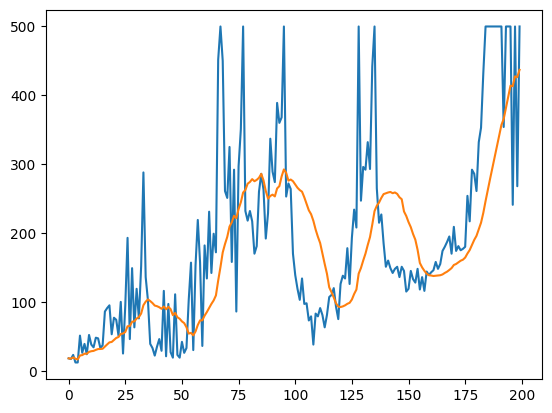

In [7]:
print_plot(r_records)

### Dyna-Q

## Mountain Car

In [14]:
mc_env = gym.make('MountainCar-v0', render_mode = 'human')
print_info(mc_env)

gamma = 0.9
actor_mc = Actor_Policy(2, 3).to(dev)
critic_mc = Critic(2).to(dev)

actor_mc_opt = torch.optim.AdamW(actor_mc.parameters(), lr = 0.001)
critic_mc_opt = torch.optim.AdamW(critic_mc.parameters(), lr = 0.003)

Action Space: Discrete(3)
Observation Space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Random action: 0
Random obs: [ 0.58401066 -0.05428831]


In [15]:
print(actor_mc, critic_mc)

Actor_Policy(
  (hidden): Linear(in_features=2, out_features=256, bias=True)
  (hidden2): Linear(in_features=256, out_features=128, bias=True)
  (hidden3): Linear(in_features=128, out_features=32, bias=True)
  (classify): Linear(in_features=32, out_features=3, bias=True)
) Critic(
  (hidden): Linear(in_features=2, out_features=512, bias=True)
  (hidden1): Linear(in_features=512, out_features=256, bias=True)
  (hidden2): Linear(in_features=256, out_features=64, bias=True)
  (hidden3): Linear(in_features=64, out_features=16, bias=True)
  (classify): Linear(in_features=16, out_features=1, bias=True)
)


In [16]:
%%time
r_records = []
# Cantidad de pasos a realizar.
for i in tqdm(range(200)):
    
    #Declaración de listas para guardar la información
    end = False
    states = []
    actions = []
    rewards = []
    s, _ = mc_env.reset()

    # Muestreo de acciones, estados, y recompensas.
    while not end:
        states.append(s.tolist())
        act = sample(s, actor_mc, False)
        s, r, term, trunc, _ = mc_env.step(act)
        end = term or trunc
        actions.append(act)
        rewards.append(r)

    # Calculamos los valores de recompensa para cada valor.
    g_rewards = np.zeros_like(rewards)
    r_len = len(rewards)
    for i in reversed(range(r_len)):
        g_rewards[i] = rewards[i] + (g_rewards[i+1]*gamma if i+1 < r_len else 0)

    # Vamos a trabajar con el crítico primero para poder reajustar al agente de manera adecuada.
    # El reajuste de los pesos W se debe de hacer mediante el entrenamiento de la red correspondiente, dígase critic().
    critic_mc_opt.zero_grad()
    states = torch.tensor(states, dtype=torch.float).to(dev)
    g_rewards = torch.tensor(g_rewards, dtype = torch.float).to(dev)
    val = critic_mc(states)
    val = val.squeeze(dim=1)
    v_loss = F.mse_loss(
        val,
        g_rewards,
        reduction = 'none'
    )
    v_loss.sum().backward()
    critic_mc_opt.step()

    # Lo que sigue es para el actor.
    actor_mc_opt.zero_grad()
    with torch.no_grad():
        val = critic_mc(states) # Inicializamos la función de valor en función del crítico
    act = torch.tensor(actions, dtype=torch.int64).to(dev)
    adv = g_rewards - val # No sé por qué pingas anda haciendo esta madre ahorita.
    logs = actor_mc(states)
    log_probs = -F.cross_entropy(logs, act, reduction='none')
    act_loss = -log_probs * adv
    act_loss.sum().backward()
    actor_mc_opt.step()

    print(f"Episodio: {i}. Recompensa: {sum(rewards)}")
    r_records.append(sum(rewards))
    
print("Acabamos. Viva Messi.")
mc_env.close()

  0%|          | 1/200 [00:06<22:21,  6.74s/it]

Episodio: 0. Recompensa: -200.0


  1%|          | 2/200 [00:13<22:19,  6.76s/it]

Episodio: 0. Recompensa: -200.0


  2%|▏         | 3/200 [00:20<22:15,  6.78s/it]

Episodio: 0. Recompensa: -200.0


  2%|▏         | 4/200 [00:27<22:05,  6.76s/it]

Episodio: 0. Recompensa: -200.0


  2%|▎         | 5/200 [00:33<21:57,  6.76s/it]

Episodio: 0. Recompensa: -200.0


  3%|▎         | 6/200 [00:40<21:49,  6.75s/it]

Episodio: 0. Recompensa: -200.0


  4%|▎         | 7/200 [00:47<21:43,  6.76s/it]

Episodio: 0. Recompensa: -200.0


  4%|▍         | 8/200 [00:54<21:37,  6.76s/it]

Episodio: 0. Recompensa: -200.0


  4%|▍         | 9/200 [01:00<21:31,  6.76s/it]

Episodio: 0. Recompensa: -200.0


  5%|▌         | 10/200 [01:07<21:26,  6.77s/it]

Episodio: 0. Recompensa: -200.0


  6%|▌         | 11/200 [01:14<21:17,  6.76s/it]

Episodio: 0. Recompensa: -200.0


  6%|▌         | 12/200 [01:21<21:09,  6.75s/it]

Episodio: 0. Recompensa: -200.0


  6%|▋         | 13/200 [01:27<21:01,  6.75s/it]

Episodio: 0. Recompensa: -200.0


  7%|▋         | 14/200 [01:34<20:54,  6.75s/it]

Episodio: 0. Recompensa: -200.0


  8%|▊         | 15/200 [01:41<20:48,  6.75s/it]

Episodio: 0. Recompensa: -200.0


  8%|▊         | 16/200 [01:48<20:41,  6.75s/it]

Episodio: 0. Recompensa: -200.0


  8%|▊         | 17/200 [01:54<20:34,  6.74s/it]

Episodio: 0. Recompensa: -200.0


  9%|▉         | 18/200 [02:01<20:26,  6.74s/it]

Episodio: 0. Recompensa: -200.0


 10%|▉         | 19/200 [02:08<20:17,  6.73s/it]

Episodio: 0. Recompensa: -200.0


 10%|█         | 20/200 [02:14<20:09,  6.72s/it]

Episodio: 0. Recompensa: -200.0


 10%|█         | 21/200 [02:21<20:01,  6.71s/it]

Episodio: 0. Recompensa: -200.0


 11%|█         | 22/200 [02:28<19:55,  6.72s/it]

Episodio: 0. Recompensa: -200.0


 12%|█▏        | 23/200 [02:35<19:48,  6.71s/it]

Episodio: 0. Recompensa: -200.0


 12%|█▏        | 24/200 [02:41<19:42,  6.72s/it]

Episodio: 0. Recompensa: -200.0


 12%|█▎        | 25/200 [02:48<19:35,  6.72s/it]

Episodio: 0. Recompensa: -200.0


 13%|█▎        | 26/200 [02:55<19:27,  6.71s/it]

Episodio: 0. Recompensa: -200.0


 14%|█▎        | 27/200 [03:01<19:21,  6.71s/it]

Episodio: 0. Recompensa: -200.0


 14%|█▍        | 28/200 [03:08<19:19,  6.74s/it]

Episodio: 0. Recompensa: -200.0


 14%|█▍        | 29/200 [03:15<19:11,  6.73s/it]

Episodio: 0. Recompensa: -200.0


 15%|█▌        | 30/200 [03:22<19:05,  6.74s/it]

Episodio: 0. Recompensa: -200.0


 16%|█▌        | 31/200 [03:28<18:57,  6.73s/it]

Episodio: 0. Recompensa: -200.0


 16%|█▌        | 32/200 [03:35<18:49,  6.72s/it]

Episodio: 0. Recompensa: -200.0


 16%|█▋        | 33/200 [03:42<18:42,  6.72s/it]

Episodio: 0. Recompensa: -200.0


 17%|█▋        | 34/200 [03:49<18:36,  6.72s/it]

Episodio: 0. Recompensa: -200.0


 18%|█▊        | 35/200 [03:55<18:27,  6.71s/it]

Episodio: 0. Recompensa: -200.0


 18%|█▊        | 36/200 [04:02<18:21,  6.72s/it]

Episodio: 0. Recompensa: -200.0


 18%|█▊        | 37/200 [04:09<18:15,  6.72s/it]

Episodio: 0. Recompensa: -200.0


 19%|█▉        | 38/200 [04:15<18:07,  6.71s/it]

Episodio: 0. Recompensa: -200.0


 20%|█▉        | 39/200 [04:22<18:00,  6.71s/it]

Episodio: 0. Recompensa: -200.0


 20%|██        | 40/200 [04:29<17:53,  6.71s/it]

Episodio: 0. Recompensa: -200.0


 20%|██        | 41/200 [04:36<17:52,  6.75s/it]

Episodio: 0. Recompensa: -200.0


 21%|██        | 42/200 [04:42<17:45,  6.75s/it]

Episodio: 0. Recompensa: -200.0


 22%|██▏       | 43/200 [04:49<17:38,  6.74s/it]

Episodio: 0. Recompensa: -200.0


 22%|██▏       | 44/200 [04:56<17:31,  6.74s/it]

Episodio: 0. Recompensa: -200.0


 22%|██▎       | 45/200 [05:03<17:24,  6.74s/it]

Episodio: 0. Recompensa: -200.0


 23%|██▎       | 46/200 [05:09<17:17,  6.74s/it]

Episodio: 0. Recompensa: -200.0


 24%|██▎       | 47/200 [05:16<17:09,  6.73s/it]

Episodio: 0. Recompensa: -200.0


 24%|██▍       | 48/200 [05:23<17:03,  6.73s/it]

Episodio: 0. Recompensa: -200.0


 24%|██▍       | 49/200 [05:30<16:56,  6.73s/it]

Episodio: 0. Recompensa: -200.0


 25%|██▌       | 50/200 [05:36<16:49,  6.73s/it]

Episodio: 0. Recompensa: -200.0


 26%|██▌       | 51/200 [05:43<16:41,  6.72s/it]

Episodio: 0. Recompensa: -200.0


 26%|██▌       | 52/200 [05:50<16:35,  6.73s/it]

Episodio: 0. Recompensa: -200.0


 26%|██▋       | 53/200 [05:56<16:27,  6.72s/it]

Episodio: 0. Recompensa: -200.0


 27%|██▋       | 54/200 [06:03<16:23,  6.73s/it]

Episodio: 0. Recompensa: -200.0


 28%|██▊       | 55/200 [06:10<16:14,  6.72s/it]

Episodio: 0. Recompensa: -200.0


 28%|██▊       | 56/200 [06:17<16:08,  6.73s/it]

Episodio: 0. Recompensa: -200.0


 28%|██▊       | 57/200 [06:23<16:02,  6.73s/it]

Episodio: 0. Recompensa: -200.0


 29%|██▉       | 58/200 [06:30<15:56,  6.73s/it]

Episodio: 0. Recompensa: -200.0


 30%|██▉       | 59/200 [06:37<15:48,  6.73s/it]

Episodio: 0. Recompensa: -200.0


 30%|███       | 60/200 [06:44<15:41,  6.73s/it]

Episodio: 0. Recompensa: -200.0


 30%|███       | 61/200 [06:50<15:34,  6.72s/it]

Episodio: 0. Recompensa: -200.0


 31%|███       | 62/200 [06:57<15:27,  6.72s/it]

Episodio: 0. Recompensa: -200.0


 32%|███▏      | 63/200 [07:04<15:19,  6.71s/it]

Episodio: 0. Recompensa: -200.0


 32%|███▏      | 64/200 [07:10<15:13,  6.71s/it]

Episodio: 0. Recompensa: -200.0


 32%|███▎      | 65/200 [07:17<15:07,  6.72s/it]

Episodio: 0. Recompensa: -200.0


 33%|███▎      | 66/200 [07:24<15:00,  6.72s/it]

Episodio: 0. Recompensa: -200.0


 34%|███▎      | 67/200 [07:31<14:53,  6.72s/it]

Episodio: 0. Recompensa: -200.0


 34%|███▍      | 68/200 [07:37<14:47,  6.72s/it]

Episodio: 0. Recompensa: -200.0


 34%|███▍      | 69/200 [07:44<14:39,  6.71s/it]

Episodio: 0. Recompensa: -200.0


 35%|███▌      | 70/200 [07:51<14:33,  6.72s/it]

Episodio: 0. Recompensa: -200.0


 36%|███▌      | 71/200 [07:57<14:26,  6.72s/it]

Episodio: 0. Recompensa: -200.0


 36%|███▌      | 72/200 [08:04<14:19,  6.72s/it]

Episodio: 0. Recompensa: -200.0


 36%|███▋      | 73/200 [08:11<14:12,  6.71s/it]

Episodio: 0. Recompensa: -200.0


 37%|███▋      | 74/200 [08:18<14:06,  6.72s/it]

Episodio: 0. Recompensa: -200.0


 38%|███▊      | 75/200 [08:24<13:58,  6.71s/it]

Episodio: 0. Recompensa: -200.0


 38%|███▊      | 76/200 [08:31<13:52,  6.71s/it]

Episodio: 0. Recompensa: -200.0


 38%|███▊      | 77/200 [08:38<13:44,  6.71s/it]

Episodio: 0. Recompensa: -200.0


 39%|███▉      | 78/200 [08:44<13:38,  6.71s/it]

Episodio: 0. Recompensa: -200.0


 40%|███▉      | 79/200 [08:51<13:31,  6.71s/it]

Episodio: 0. Recompensa: -200.0


 40%|████      | 80/200 [08:58<13:25,  6.71s/it]

Episodio: 0. Recompensa: -200.0


 40%|████      | 81/200 [09:04<13:18,  6.71s/it]

Episodio: 0. Recompensa: -200.0


 41%|████      | 82/200 [09:11<13:14,  6.73s/it]

Episodio: 0. Recompensa: -200.0


 42%|████▏     | 83/200 [09:18<13:07,  6.73s/it]

Episodio: 0. Recompensa: -200.0


 42%|████▏     | 84/200 [09:25<13:03,  6.75s/it]

Episodio: 0. Recompensa: -200.0


 42%|████▎     | 85/200 [09:32<12:57,  6.76s/it]

Episodio: 0. Recompensa: -200.0


 43%|████▎     | 86/200 [09:38<12:49,  6.75s/it]

Episodio: 0. Recompensa: -200.0


 44%|████▎     | 87/200 [09:45<12:41,  6.74s/it]

Episodio: 0. Recompensa: -200.0


 44%|████▍     | 88/200 [09:52<12:34,  6.74s/it]

Episodio: 0. Recompensa: -200.0


 44%|████▍     | 89/200 [09:58<12:27,  6.74s/it]

Episodio: 0. Recompensa: -200.0


 45%|████▌     | 90/200 [10:05<12:21,  6.74s/it]

Episodio: 0. Recompensa: -200.0


 46%|████▌     | 91/200 [10:12<12:14,  6.73s/it]

Episodio: 0. Recompensa: -200.0


 46%|████▌     | 92/200 [10:19<12:07,  6.74s/it]

Episodio: 0. Recompensa: -200.0


 46%|████▋     | 93/200 [10:25<12:00,  6.73s/it]

Episodio: 0. Recompensa: -200.0


 47%|████▋     | 94/200 [10:32<11:54,  6.74s/it]

Episodio: 0. Recompensa: -200.0


 48%|████▊     | 95/200 [10:39<11:47,  6.73s/it]

Episodio: 0. Recompensa: -200.0


 48%|████▊     | 96/200 [10:46<11:40,  6.74s/it]

Episodio: 0. Recompensa: -200.0


 48%|████▊     | 97/200 [10:52<11:35,  6.76s/it]

Episodio: 0. Recompensa: -200.0


 49%|████▉     | 98/200 [10:59<11:29,  6.76s/it]

Episodio: 0. Recompensa: -200.0


 50%|████▉     | 99/200 [11:06<11:21,  6.75s/it]

Episodio: 0. Recompensa: -200.0


 50%|█████     | 100/200 [11:13<11:14,  6.74s/it]

Episodio: 0. Recompensa: -200.0


 50%|█████     | 101/200 [11:19<11:07,  6.74s/it]

Episodio: 0. Recompensa: -200.0


 51%|█████     | 102/200 [11:26<11:00,  6.74s/it]

Episodio: 0. Recompensa: -200.0


 52%|█████▏    | 103/200 [11:33<10:53,  6.73s/it]

Episodio: 0. Recompensa: -200.0


 52%|█████▏    | 104/200 [11:40<10:46,  6.73s/it]

Episodio: 0. Recompensa: -200.0


 52%|█████▎    | 105/200 [11:46<10:39,  6.74s/it]

Episodio: 0. Recompensa: -200.0


 53%|█████▎    | 106/200 [11:53<10:34,  6.75s/it]

Episodio: 0. Recompensa: -200.0


 54%|█████▎    | 107/200 [12:00<10:26,  6.74s/it]

Episodio: 0. Recompensa: -200.0


 54%|█████▍    | 108/200 [12:07<10:20,  6.75s/it]

Episodio: 0. Recompensa: -200.0


 55%|█████▍    | 109/200 [12:13<10:14,  6.75s/it]

Episodio: 0. Recompensa: -200.0


 55%|█████▌    | 110/200 [12:20<10:07,  6.75s/it]

Episodio: 0. Recompensa: -200.0


 56%|█████▌    | 111/200 [12:27<10:00,  6.75s/it]

Episodio: 0. Recompensa: -200.0


 56%|█████▌    | 112/200 [12:34<09:53,  6.75s/it]

Episodio: 0. Recompensa: -200.0


 56%|█████▋    | 113/200 [12:40<09:46,  6.74s/it]

Episodio: 0. Recompensa: -200.0


 57%|█████▋    | 114/200 [12:47<09:39,  6.74s/it]

Episodio: 0. Recompensa: -200.0


 57%|█████▊    | 115/200 [12:54<09:32,  6.73s/it]

Episodio: 0. Recompensa: -200.0


 58%|█████▊    | 116/200 [13:01<09:26,  6.75s/it]

Episodio: 0. Recompensa: -200.0


 58%|█████▊    | 117/200 [13:07<09:19,  6.75s/it]

Episodio: 0. Recompensa: -200.0


 59%|█████▉    | 118/200 [13:14<09:15,  6.78s/it]

Episodio: 0. Recompensa: -200.0


 60%|█████▉    | 119/200 [13:21<09:08,  6.77s/it]

Episodio: 0. Recompensa: -200.0


 60%|██████    | 120/200 [13:28<09:02,  6.78s/it]

Episodio: 0. Recompensa: -200.0


 60%|██████    | 121/200 [13:34<08:54,  6.76s/it]

Episodio: 0. Recompensa: -200.0


 61%|██████    | 122/200 [13:41<08:49,  6.79s/it]

Episodio: 0. Recompensa: -200.0


 62%|██████▏   | 123/200 [13:48<08:42,  6.79s/it]

Episodio: 0. Recompensa: -200.0


 62%|██████▏   | 124/200 [13:55<08:35,  6.78s/it]

Episodio: 0. Recompensa: -200.0


 62%|██████▎   | 125/200 [14:02<08:29,  6.79s/it]

Episodio: 0. Recompensa: -200.0


 63%|██████▎   | 126/200 [14:08<08:21,  6.77s/it]

Episodio: 0. Recompensa: -200.0


 64%|██████▎   | 127/200 [14:15<08:13,  6.76s/it]

Episodio: 0. Recompensa: -200.0


 64%|██████▍   | 128/200 [14:22<08:06,  6.76s/it]

Episodio: 0. Recompensa: -200.0


 64%|██████▍   | 129/200 [14:29<08:00,  6.77s/it]

Episodio: 0. Recompensa: -200.0


 65%|██████▌   | 130/200 [14:35<07:52,  6.75s/it]

Episodio: 0. Recompensa: -200.0


 66%|██████▌   | 131/200 [14:42<07:44,  6.74s/it]

Episodio: 0. Recompensa: -200.0


 66%|██████▌   | 132/200 [14:49<07:37,  6.73s/it]

Episodio: 0. Recompensa: -200.0


 66%|██████▋   | 133/200 [14:55<07:30,  6.73s/it]

Episodio: 0. Recompensa: -200.0


 67%|██████▋   | 134/200 [15:02<07:23,  6.73s/it]

Episodio: 0. Recompensa: -200.0


 68%|██████▊   | 135/200 [15:09<07:17,  6.74s/it]

Episodio: 0. Recompensa: -200.0


 68%|██████▊   | 136/200 [15:16<07:11,  6.75s/it]

Episodio: 0. Recompensa: -200.0


 68%|██████▊   | 137/200 [15:22<07:04,  6.74s/it]

Episodio: 0. Recompensa: -200.0


 69%|██████▉   | 138/200 [15:29<06:57,  6.74s/it]

Episodio: 0. Recompensa: -200.0


 70%|██████▉   | 139/200 [15:36<06:50,  6.73s/it]

Episodio: 0. Recompensa: -200.0


 70%|███████   | 140/200 [15:43<06:44,  6.74s/it]

Episodio: 0. Recompensa: -200.0


 70%|███████   | 141/200 [15:49<06:37,  6.74s/it]

Episodio: 0. Recompensa: -200.0


 71%|███████   | 142/200 [15:56<06:30,  6.73s/it]

Episodio: 0. Recompensa: -200.0


 72%|███████▏  | 143/200 [16:03<06:24,  6.74s/it]

Episodio: 0. Recompensa: -200.0


 72%|███████▏  | 144/200 [16:10<06:17,  6.74s/it]

Episodio: 0. Recompensa: -200.0


 72%|███████▎  | 145/200 [16:16<06:10,  6.74s/it]

Episodio: 0. Recompensa: -200.0


 73%|███████▎  | 146/200 [16:23<06:04,  6.75s/it]

Episodio: 0. Recompensa: -200.0


 74%|███████▎  | 147/200 [16:30<05:56,  6.73s/it]

Episodio: 0. Recompensa: -200.0


 74%|███████▍  | 148/200 [16:37<05:50,  6.74s/it]

Episodio: 0. Recompensa: -200.0


 74%|███████▍  | 149/200 [16:43<05:43,  6.73s/it]

Episodio: 0. Recompensa: -200.0


 75%|███████▌  | 150/200 [16:50<05:36,  6.73s/it]

Episodio: 0. Recompensa: -200.0


 76%|███████▌  | 151/200 [16:57<05:29,  6.72s/it]

Episodio: 0. Recompensa: -200.0


 76%|███████▌  | 152/200 [17:03<05:23,  6.73s/it]

Episodio: 0. Recompensa: -200.0


 76%|███████▋  | 153/200 [17:10<05:16,  6.73s/it]

Episodio: 0. Recompensa: -200.0


 77%|███████▋  | 154/200 [17:17<05:09,  6.73s/it]

Episodio: 0. Recompensa: -200.0


 78%|███████▊  | 155/200 [17:24<05:02,  6.73s/it]

Episodio: 0. Recompensa: -200.0


 78%|███████▊  | 156/200 [17:30<04:56,  6.74s/it]

Episodio: 0. Recompensa: -200.0


 78%|███████▊  | 157/200 [17:37<04:49,  6.73s/it]

Episodio: 0. Recompensa: -200.0


 79%|███████▉  | 158/200 [17:44<04:42,  6.73s/it]

Episodio: 0. Recompensa: -200.0


 80%|███████▉  | 159/200 [17:51<04:35,  6.72s/it]

Episodio: 0. Recompensa: -200.0


 80%|████████  | 160/200 [17:57<04:28,  6.72s/it]

Episodio: 0. Recompensa: -200.0


 80%|████████  | 161/200 [18:04<04:22,  6.72s/it]

Episodio: 0. Recompensa: -200.0


 81%|████████  | 162/200 [18:11<04:15,  6.72s/it]

Episodio: 0. Recompensa: -200.0


 82%|████████▏ | 163/200 [18:17<04:08,  6.71s/it]

Episodio: 0. Recompensa: -200.0


 82%|████████▏ | 164/200 [18:24<04:01,  6.72s/it]

Episodio: 0. Recompensa: -200.0


 82%|████████▎ | 165/200 [18:31<03:55,  6.72s/it]

Episodio: 0. Recompensa: -200.0


 83%|████████▎ | 166/200 [18:38<03:48,  6.72s/it]

Episodio: 0. Recompensa: -200.0


 84%|████████▎ | 167/200 [18:44<03:41,  6.72s/it]

Episodio: 0. Recompensa: -200.0


 84%|████████▍ | 168/200 [18:51<03:34,  6.72s/it]

Episodio: 0. Recompensa: -200.0


 84%|████████▍ | 169/200 [18:58<03:28,  6.72s/it]

Episodio: 0. Recompensa: -200.0


 85%|████████▌ | 170/200 [19:04<03:21,  6.72s/it]

Episodio: 0. Recompensa: -200.0


 86%|████████▌ | 171/200 [19:11<03:14,  6.71s/it]

Episodio: 0. Recompensa: -200.0


 86%|████████▌ | 172/200 [19:18<03:08,  6.72s/it]

Episodio: 0. Recompensa: -200.0


 86%|████████▋ | 173/200 [19:25<03:01,  6.71s/it]

Episodio: 0. Recompensa: -200.0


 87%|████████▋ | 174/200 [19:31<02:54,  6.71s/it]

Episodio: 0. Recompensa: -200.0


 88%|████████▊ | 175/200 [19:38<02:47,  6.71s/it]

Episodio: 0. Recompensa: -200.0


 88%|████████▊ | 176/200 [19:45<02:41,  6.71s/it]

Episodio: 0. Recompensa: -200.0


 88%|████████▊ | 177/200 [19:51<02:34,  6.71s/it]

Episodio: 0. Recompensa: -200.0


 89%|████████▉ | 178/200 [19:58<02:27,  6.70s/it]

Episodio: 0. Recompensa: -200.0


 90%|████████▉ | 179/200 [20:05<02:20,  6.71s/it]

Episodio: 0. Recompensa: -200.0


 90%|█████████ | 180/200 [20:12<02:14,  6.71s/it]

Episodio: 0. Recompensa: -200.0


 90%|█████████ | 181/200 [20:18<02:07,  6.70s/it]

Episodio: 0. Recompensa: -200.0


 91%|█████████ | 182/200 [20:25<02:00,  6.71s/it]

Episodio: 0. Recompensa: -200.0


 92%|█████████▏| 183/200 [20:32<01:54,  6.71s/it]

Episodio: 0. Recompensa: -200.0


 92%|█████████▏| 184/200 [20:38<01:47,  6.72s/it]

Episodio: 0. Recompensa: -200.0


 92%|█████████▎| 185/200 [20:45<01:40,  6.72s/it]

Episodio: 0. Recompensa: -200.0


 93%|█████████▎| 186/200 [20:52<01:34,  6.72s/it]

Episodio: 0. Recompensa: -200.0


 94%|█████████▎| 187/200 [20:59<01:27,  6.72s/it]

Episodio: 0. Recompensa: -200.0


 94%|█████████▍| 188/200 [21:05<01:20,  6.72s/it]

Episodio: 0. Recompensa: -200.0


 94%|█████████▍| 189/200 [21:12<01:13,  6.71s/it]

Episodio: 0. Recompensa: -200.0


 95%|█████████▌| 190/200 [21:19<01:07,  6.71s/it]

Episodio: 0. Recompensa: -200.0


 96%|█████████▌| 191/200 [21:25<01:00,  6.71s/it]

Episodio: 0. Recompensa: -200.0


 96%|█████████▌| 192/200 [21:32<00:53,  6.70s/it]

Episodio: 0. Recompensa: -200.0


 96%|█████████▋| 193/200 [21:39<00:46,  6.71s/it]

Episodio: 0. Recompensa: -200.0


 97%|█████████▋| 194/200 [21:46<00:40,  6.71s/it]

Episodio: 0. Recompensa: -200.0


 98%|█████████▊| 195/200 [21:52<00:33,  6.70s/it]

Episodio: 0. Recompensa: -200.0


 98%|█████████▊| 196/200 [21:59<00:26,  6.70s/it]

Episodio: 0. Recompensa: -200.0


 98%|█████████▊| 197/200 [22:06<00:20,  6.71s/it]

Episodio: 0. Recompensa: -200.0


 99%|█████████▉| 198/200 [22:12<00:13,  6.72s/it]

Episodio: 0. Recompensa: -200.0


100%|█████████▉| 199/200 [22:19<00:06,  6.72s/it]

Episodio: 0. Recompensa: -200.0


100%|██████████| 200/200 [22:26<00:00,  6.73s/it]

Episodio: 0. Recompensa: -200.0
Acabamos. Viva Messi.
CPU times: total: 1min 27s
Wall time: 22min 26s


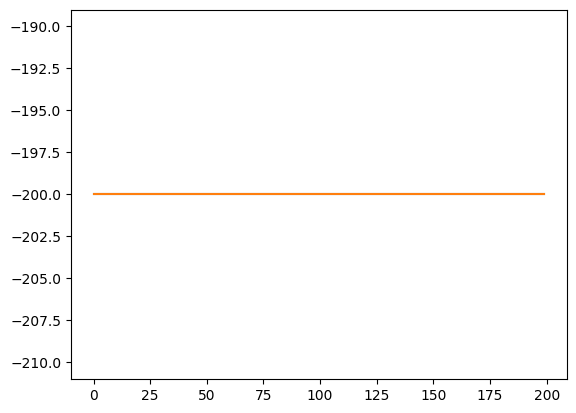

In [17]:
print_plot(r_records)

## Breakout

In [32]:
from minatar import Environment
import numpy as np
#import matplotlib.pyplot as plt

# Crear el entorno de MinAtar para el juego Breakout
env = Environment("breakout")
num_acciones = env.num_actions()
forma_estado = env.state_shape()
dim_estado = np.prod(forma_estado)
print(num_acciones, forma_estado, dim_estado)

6 [10, 10, 4] 400


In [51]:
actor_breakout = Actor_Policy(4, 6).to(dev)
critic_breakout = Critic(4).to(dev)

a_b_opt = torch.optim.AdamW(actor_breakout.parameters(), lr = 0.001)
c_b_opt = torch.optim.AdamW(critic_breakout.parameters(), lr = 0.001)

In [62]:
for i in range(6):
    env.reset()
    print(i)
    aux = env.act(i)
    print(aux)

0
(0, False)
1
(0, False)
2
(0, False)
3
(0, False)
4
(0, False)
5
(0, False)


In [53]:
states = []
actions = []
rewards = []
end = False

s = env.reset()
s = env.state()

while not end:
    states.append(s.tolist())
    s.flatten()
    action = sample(s, actor_breakout, True)
    reward, term = env.act(action)
    end = term

torch.Size([10, 10, 6])
torch.Size([10, 10, 6])
torch.Size([1])
6
----


IndexError: list index out of range

____________________

In [15]:
import shimmy
import minatar

gym.register('MinAtar/Breakout-v1', minatar)
print(gym.envs.registration.registry.keys())
b_env = gym.make('MinAtar/Breakout-v1', render_mode = 'human')

dict_keys(['CartPole-v0', 'CartPole-v1', 'MountainCar-v0', 'MountainCarContinuous-v0', 'Pendulum-v1', 'Acrobot-v1', 'phys2d/CartPole-v0', 'phys2d/CartPole-v1', 'phys2d/Pendulum-v0', 'LunarLander-v3', 'LunarLanderContinuous-v3', 'BipedalWalker-v3', 'BipedalWalkerHardcore-v3', 'CarRacing-v3', 'Blackjack-v1', 'FrozenLake-v1', 'FrozenLake8x8-v1', 'CliffWalking-v0', 'Taxi-v3', 'tabular/Blackjack-v0', 'tabular/CliffWalking-v0', 'Reacher-v2', 'Reacher-v4', 'Reacher-v5', 'Pusher-v2', 'Pusher-v4', 'Pusher-v5', 'InvertedPendulum-v2', 'InvertedPendulum-v4', 'InvertedPendulum-v5', 'InvertedDoublePendulum-v2', 'InvertedDoublePendulum-v4', 'InvertedDoublePendulum-v5', 'HalfCheetah-v2', 'HalfCheetah-v3', 'HalfCheetah-v4', 'HalfCheetah-v5', 'Hopper-v2', 'Hopper-v3', 'Hopper-v4', 'Hopper-v5', 'Swimmer-v2', 'Swimmer-v3', 'Swimmer-v4', 'Swimmer-v5', 'Walker2d-v2', 'Walker2d-v3', 'Walker2d-v4', 'Walker2d-v5', 'Ant-v2', 'Ant-v3', 'Ant-v4', 'Ant-v5', 'Humanoid-v2', 'Humanoid-v3', 'Humanoid-v4', 'Humanoid-v5

AttributeError: module 'minatar' has no attribute 'split'